## Download LJSpeech

In [1]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!tar -xjf LJSpeech-1.1.tar.bz2

--2021-12-03 13:44:50--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  47.3MB/s    in 57s     

2021-12-03 13:45:48 (45.8 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [2]:
!pip install librosa

In [3]:
!pip install torch==1.10.0+cu111 torchaudio==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


## Featurizer

In [4]:
from IPython import display
from dataclasses import dataclass

import torch
from torch import nn

import torchaudio

import librosa
from matplotlib import pyplot as plt


@dataclass
class MelSpectrogramConfig:
    sr: int = 22050
    win_length: int = 1024
    hop_length: int = 256
    n_fft: int = 1024
    f_min: int = 0
    f_max: int = 8000
    n_mels: int = 80
    power: float = 1.0

    # value of melspectrograms if we fed a silence into `MelSpectrogram`
    pad_value: float = -11.5129251


class MelSpectrogram(nn.Module):

    def __init__(self, config: MelSpectrogramConfig):
        super(MelSpectrogram, self).__init__()

        self.config = config

        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.sr,
            win_length=config.win_length,
            hop_length=config.hop_length,
            n_fft=config.n_fft,
            f_min=config.f_min,
            f_max=config.f_max,
            n_mels=config.n_mels
        )

        # The is no way to set power in constructor in 0.5.0 version.
        self.mel_spectrogram.spectrogram.power = config.power

        # Default `torchaudio` mel basis uses HTK formula. In order to be compatible with WaveGlow
        # we decided to use Slaney one instead (as well as `librosa` does by default).
        mel_basis = librosa.filters.mel(
            sr=config.sr,
            n_fft=config.n_fft,
            n_mels=config.n_mels,
            fmin=config.f_min,
            fmax=config.f_max
        ).T
        self.mel_spectrogram.mel_scale.fb.copy_(torch.tensor(mel_basis))

    def forward(self, audio: torch.Tensor) -> torch.Tensor:
        """
        :param audio: Expected shape is [B, T]
        :return: Shape is [B, n_mels, T']
        """

        mel = self.mel_spectrogram(audio) \
            .clamp_(min=1e-5) \
            .log_()

        return mel

In [5]:
featurizer = MelSpectrogram(MelSpectrogramConfig())

---

## Dataset

In [6]:
class LJSpeechDataset(torchaudio.datasets.LJSPEECH):

    def __init__(self, root):
        super().__init__(root=root)
        self._tokenizer = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH.get_text_processor()

    def __getitem__(self, index: int):
        waveform, _, _, transcript = super().__getitem__(index)
        waveforn_length = torch.tensor([waveform.shape[-1]]).int()
        
        tokens, token_lengths = self._tokenizer(transcript)
        
        return waveform, waveforn_length, transcript, tokens, token_lengths
    
    def decode(self, tokens, lengths):
        result = []
        for tokens_, length in zip(tokens, lengths):
            text = "".join([
                self._tokenizer.tokens[token]
                for token in tokens_[:length]
            ])
            result.append(text)
        return result
                

In [7]:
dataset = LJSpeechDataset('.')

In [8]:
dataset[0]

(tensor([[-7.3242e-04, -7.6294e-04, -6.4087e-04,  ...,  7.3242e-04,
           2.1362e-04,  6.1035e-05]]),
 tensor([212893], dtype=torch.int32),
 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition',
 tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
          25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
          14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
          25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
          16, 29, 30, 11, 17, 29, 26, 24, 11, 24, 26, 30, 31, 11, 20, 17, 11, 25,
          26, 31, 11, 17, 29, 26, 24, 11, 12, 23, 23, 11, 31, 19, 16, 11, 12, 29,
          31, 30, 11, 12, 25, 15, 11, 14, 29, 12, 17, 31, 30, 11, 29, 16, 27, 29,
          16, 30, 16, 25, 31, 16, 15, 11, 20, 25, 11, 31, 19, 16, 11, 16, 35, 19,
          20, 13, 20, 31, 20, 26, 25]]),
 t

In [9]:
from typing import Tuple, Dict, Optional, List, Union
from itertools import islice

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


@dataclass
class Batch:
    waveform: torch.Tensor
    waveforn_length: torch.Tensor
    transcript: List[str]
    tokens: torch.Tensor
    token_lengths: torch.Tensor
    durations: Optional[torch.Tensor] = None
        
    def to(self, device: torch.device) -> 'Batch':
        raise NotImplementedError


class LJSpeechCollator:

    def __call__(self, instances: List[Tuple]) -> Dict:
        waveform, waveforn_length, transcript, tokens, token_lengths = list(
            zip(*instances)
        )

        waveform = pad_sequence([
            waveform_[0] for waveform_ in waveform
        ]).transpose(0, 1)
        waveforn_length = torch.cat(waveforn_length)

        tokens = pad_sequence([
            tokens_[0] for tokens_ in tokens
        ]).transpose(0, 1)
        token_lengths = torch.cat(token_lengths)

        return Batch(waveform, waveforn_length, transcript, tokens, token_lengths)

In [10]:
dataloader = DataLoader(LJSpeechDataset('.'), batch_size=3, collate_fn=LJSpeechCollator())

In [11]:
dummy_batch = list(islice(dataloader, 1))[0]
dummy_batch

Batch(waveform=tensor([[-0.0007, -0.0008, -0.0006,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0003,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0025, -0.0037,  0.0005,  ...,  0.0003,  0.0002, -0.0004]]), waveforn_length=tensor([212893,  41885, 213149], dtype=torch.int32), transcript=('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.', 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'), tokens=tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
         25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
         14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
         25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
         16,

---

## Vocoder

In [12]:
!git clone https://github.com/NVIDIA/waveglow.git
!pip install googledrivedownloader

Cloning into 'waveglow'...
remote: Enumerating objects: 190, done.
remote: Total 190 (delta 0), reused 0 (delta 0), pack-reused 190
Receiving objects: 100% (190/190), 435.41 KiB | 14.51 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [13]:
from google_drive_downloader import GoogleDriveDownloader as gdd

In [14]:
gdd.download_file_from_google_drive(
    file_id='1rpK8CzAAirq9sWZhe9nlfvxMF1dRgFbF',
    dest_path='./waveglow_256channels_universal_v5.pt'
)

In [15]:
import warnings
import sys
sys.path.append('waveglow/')

warnings.filterwarnings('ignore')


class Vocoder(nn.Module):

    def __init__(self):
        super(Vocoder, self).__init__()

        model = torch.load('waveglow_256channels_universal_v5.pt', map_location='cpu')[
            'model']
        self.net = model.remove_weightnorm(model)

    @torch.no_grad()
    def inference(self, spect: torch.Tensor):
        spect = self.net.upsample(spect)

        # trim the conv artifacts
        time_cutoff = self.net.upsample.kernel_size[0] - \
            self.net.upsample.stride[0]
        spect = spect[:, :, :-time_cutoff]

        spect = spect.unfold(2, self.net.n_group, self.net.n_group) \
            .permute(0, 2, 1, 3) \
            .contiguous() \
            .flatten(start_dim=2) \
            .transpose(-1, -2)

        # generate prior
        audio = torch.randn(spect.size(0), self.net.n_remaining_channels, spect.size(-1)) \
            .to(spect.device)

        for k in reversed(range(self.net.n_flows)):
            n_half = int(audio.size(1) / 2)
            audio_0 = audio[:, :n_half, :]
            audio_1 = audio[:, n_half:, :]

            output = self.net.WN[k]((audio_0, spect))

            s = output[:, n_half:, :]
            b = output[:, :n_half, :]
            audio_1 = (audio_1 - b) / torch.exp(s)
            audio = torch.cat([audio_0, audio_1], 1)

            audio = self.net.convinv[k](audio, reverse=True)

            if k % self.net.n_early_every == 0 and k > 0:
                z = torch.randn(
                    spect.size(0), self.net.n_early_size, spect.size(2),
                    device=spect.device
                )
                audio = torch.cat((z, audio), 1)

        audio = audio.permute(0, 2, 1) \
            .contiguous() \
            .view(audio.size(0), -1)

        return audio

In [16]:
vocoder = Vocoder().to('cuda').eval()

In [17]:
waveform = dummy_batch.waveform[:1]
mels = featurizer(waveform).cuda()

In [18]:
waveform.shape

torch.Size([1, 213149])

In [19]:
mels[0].shape

torch.Size([80, 833])

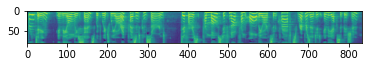

In [20]:
plt.imshow(mels[0].cpu())

In [21]:
reconstructed_wav = vocoder.inference(mels).cpu()

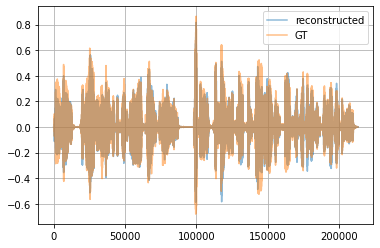

In [22]:
plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
plt.plot(waveform.squeeze(), label='GT', alpha=.5)
plt.grid()
plt.legend()
plt.show()

In [23]:
display.display(display.Audio(reconstructed_wav, rate=22050))
display.display(display.Audio(waveform, rate=22050))

---

## Grapheme Aligner

In [24]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


class GraphemeAligner(nn.Module):

    def __init__(self):
        super().__init__()

        self._wav2vec2 = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()
        self._labels = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_labels()
        self._char2index = {c: i for i, c in enumerate(self._labels)}
        self._unk_index = self._char2index['<unk>']
        self._resampler = torchaudio.transforms.Resample(
            orig_freq=MelSpectrogramConfig.sr, new_freq=16_000
        )

    def _decode_text(self, text):
        text = text.replace(' ', '|').upper()
        return torch.tensor([
            self._char2index.get(char, self._unk_index)
            for char in text
        ]).long()

    @torch.no_grad()
    def forward(
        self,
        wavs: torch.Tensor,
        wav_lengths: torch.Tensor,
        texts: Union[str, List[str]]
    ):
        if isinstance(texts, str):
            texts = [texts]
        batch_size = wavs.shape[0]

        durations = []
        for index in range(batch_size):
            current_wav = wavs[index, :wav_lengths[index]].unsqueeze(dim=0)
            current_wav = self._resampler(current_wav)
            emission, _ = self._wav2vec2(current_wav)
            emission = emission.log_softmax(dim=-1).squeeze(dim=0).cpu()

            tokens = self._decode_text(texts[index])

            trellis = self._get_trellis(emission, tokens)
            path = self._backtrack(trellis, emission, tokens)
            segments = self._merge_repeats(texts[index], path)

            num_frames = emission.shape[0]
            relative_durations = torch.tensor([
                segment.length / num_frames for segment in segments
            ])

            durations.append(relative_durations)
            
        durations = pad_sequence(durations).transpose(0, 1)
        return durations

    def _get_trellis(self, emission, tokens, blank_id=0):
        num_frame = emission.size(0)
        num_tokens = len(tokens)

        # Trellis has extra dimension for both time axis and tokens.
        # The extra dim for tokens represents <SoS> (start-of-sentence)
        # The extra dim for time axis is for simplification of the code.
        trellis = torch.full((num_frame + 1, num_tokens + 1), -float('inf'))
        trellis[:, 0] = 0
        for t in range(num_frame):
            trellis[t + 1, 1:] = torch.maximum(
                # Score for staying at the same token
                trellis[t, 1:] + emission[t, blank_id],

                # Score for changing to the next token
                trellis[t, :-1] + emission[t, tokens],
            )
        return trellis

    def _backtrack(self, trellis, emission, tokens, blank_id=0):
        # Note:
        # j and t are indices for trellis, which has extra dimensions
        # for time and tokens at the beginning.
        # When refering to time frame index `T` in trellis,
        # the corresponding index in emission is `T-1`.
        # Similarly, when refering to token index `J` in trellis,
        # the corresponding index in transcript is `J-1`.
        j = trellis.size(1) - 1
        t_start = torch.argmax(trellis[:, j]).item()

        path = []
        for t in range(t_start, 0, -1):
            # 1. Figure out if the current position was stay or change
            # Note (again):
            # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
            # Score for token staying the same from time frame J-1 to T.
            stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
            # Score for token changing from C-1 at T-1 to J at T.
            changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

            # 2. Store the path with frame-wise probability.
            prob = emission[t - 1, tokens[j - 1]
                            if changed > stayed else 0].exp().item()
            # Return token index and time index in non-trellis coordinate.
            path.append(Point(j - 1, t - 1, prob))

            # 3. Update the token
            if changed > stayed:
                j -= 1
                if j == 0:
                    break

        else:
            raise ValueError('Failed to align')

        return path[::-1]

    def _merge_repeats(self, text, path):
        i1, i2 = 0, 0
        segments = []
        while i1 < len(path):
            while i2 < len(path) and path[i1].token_index == path[i2].token_index:
                i2 += 1
            score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
            segments.append(
                Segment(
                    text[path[i1].token_index],
                    path[i1].time_index,
                    path[i2 - 1].time_index + 1,
                    score
                )
            )
            i1 = i2

        return segments

    @staticmethod
    def plot_trellis_with_path(trellis, path):
        # to plot trellis with path, we take advantage of 'nan' value
        trellis_with_path = trellis.clone()
        for i, p in enumerate(path):
            trellis_with_path[p.time_index, p.token_index] = float('nan')
        plt.imshow(trellis_with_path[1:, 1:].T, origin='lower')

In [25]:
device = torch.device('cpu')
aligner = GraphemeAligner().to(device)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

In [26]:
dummy_batch

Batch(waveform=tensor([[-0.0007, -0.0008, -0.0006,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0003,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0025, -0.0037,  0.0005,  ...,  0.0003,  0.0002, -0.0004]]), waveforn_length=tensor([212893,  41885, 213149], dtype=torch.int32), transcript=('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.', 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'), tokens=tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
         25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
         14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
         25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
         16,

In [27]:
dummy_batch.durations = aligner(
    dummy_batch.waveform.to(device), dummy_batch.waveforn_length, dummy_batch.transcript
)

In [28]:
dummy_batch

Batch(waveform=tensor([[-0.0007, -0.0008, -0.0006,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0003,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0025, -0.0037,  0.0005,  ...,  0.0003,  0.0002, -0.0004]]), waveforn_length=tensor([212893,  41885, 213149], dtype=torch.int32), transcript=('Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'in being comparatively modern.', 'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'), tokens=tensor([[27, 29, 20, 25, 31, 20, 25, 18,  6, 11, 20, 25, 11, 31, 19, 16, 11, 26,
         25, 23, 36, 11, 30, 16, 25, 30, 16, 11, 34, 20, 31, 19, 11, 34, 19, 20,
         14, 19, 11, 34, 16, 11, 12, 29, 16, 11, 12, 31, 11, 27, 29, 16, 30, 16,
         25, 31, 11, 14, 26, 25, 14, 16, 29, 25, 16, 15,  6, 11, 15, 20, 17, 17,
         16,

## Visualize

In [29]:
index = 0

waveform = dummy_batch.waveform[index][:dummy_batch.waveforn_length[index]]
durations = dummy_batch.durations[index][:dummy_batch.token_lengths[index]]

# scale by waveform domain
durations = durations * dummy_batch.waveforn_length[index]
durations = durations.cumsum(dim=0).int()

print(dummy_batch.transcript[index])
left = 0
for right, char in zip(durations[:10], dummy_batch.transcript[index]):
    print(char)
    display.display(display.Audio(waveform[left:right], rate=22050))
    left = right
    print('-' * 99)

Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
P


---------------------------------------------------------------------------------------------------
r


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
t


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
g


---------------------------------------------------------------------------------------------------
,


---------------------------------------------------------------------------------------------------
 


---------------------------------------------------------------------------------------------------


In [30]:
dummy_batch.transcript[index]

'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition'

#Model

In [31]:
import math

In [32]:
class Embed(nn.Module):
    def __init__(self,num_embeddings, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings,embedding_dim)
    def forward(self, batch):
        return self.embedding(batch)

In [33]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [34]:
import torch.nn.functional as F

Encoder

In [35]:
import copy

In [36]:
def clones(module, N):
    "Копирут блоки N раз"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [37]:
class LayerNorm(nn.Module):
    "Модуль для нормироки слоя"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [38]:
class Encoder(nn.Module):
    "Базовый кодировщик представляет собой стек из N слоев."
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x):
        "Пропускает входные данные через каждый слой"
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [39]:
def attention(query, key, value, dropout=None):
    "Вычисляет 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    p_attn = nn.functional.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [40]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Создант self-attention с h головами"
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value):
        "Implements Figure 2"
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [41]:
class Conv1d(nn.Module):
    "Вычисляет FFN блок, часть со свертками."
    def __init__(self, d_model = 384, hiden = 1536 , kernal_size = 3, dropout=0.1):
        super(Conv1d, self).__init__()
        self.conv1 = nn.Conv1d(d_model, hiden, kernal_size, padding=1)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(hiden, d_model, kernal_size, padding=1)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))
        x = self.dropout1(F.relu(self.conv1(x)))
        x = self.dropout2(F.relu(self.conv2(x)))
        x = torch.permute(x, (0, 2, 1))
        return x

In [42]:
class lenRegulator(nn.Module):
    "Модуль для регулировки длиины"
    def __init__(self, in_channels = 384, filter_size = 256,  kernal_size = 3, dropout=0.1):
        super(lenRegulator, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, filter_size,kernal_size, padding=1)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = LayerNorm(filter_size)
        self.conv2 = nn.Conv1d(filter_size, filter_size,kernal_size, padding=1)
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = LayerNorm(filter_size)
        self.linear =  nn.Linear(filter_size, 1)

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))
        x = self.conv1(x)
        x = self.norm1(torch.permute(x, (0, 2, 1)))
        x = self.dropout1(F.relu(x))
        x = self.conv2(torch.permute(x, (0, 2, 1)))
        x = self.norm2(torch.permute(x, (0, 2, 1)))
        x = self.dropout2(F.relu(torch.permute(x, (0, 2, 1))))
        x = torch.permute(x, (0, 2, 1))
        x = self.linear(x)
        return x

In [43]:
class Linear_Layer(nn.Module):
    "Последний слой модели, выдает блоки [B, n_mels, Time]"
    def __init__(self, in_channels = 384, filter_size = 80, dropout=0.1):
        super(Linear_Layer, self).__init__()
        self.linear = nn.Linear(in_channels, filter_size)

    def forward(self, x):
        x = self.linear(x)
        return x

In [44]:
class SublayerConnection(nn.Module):
    """
    Модуль перебрски весов( residual connection)
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        out = self.norm(x)
        out = sublayer(out)
        out = self.dropout(out)
        return x + out

In [45]:
class EncoderLayer(nn.Module):
    "один FFT Block "
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x):
        "-----------"
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x))
        return self.sublayer[1](x, self.feed_forward)

In [46]:
class Model(nn.Module):
    """
    Feed-Forward Transformer модель
    """
    def __init__(self,embedding, position_emb, encoder, duration_predictor, decoder, position_emb2, generator):
        super(Model, self).__init__()
       
        self.embedding = embedding
        self.position_emb = position_emb

        self.encoder = encoder
        self.duration_predictor = duration_predictor
        self.decoder = decoder
        self.position_emb2 = position_emb2
        self.generator = generator
        
    def forward(self, src, input_dur_inframe = None, device="cuda"):
        "-----"
        encode = self.encode(src)

        if input_dur_inframe is not None:
            input_dur_inframe = input_dur_inframe.long()
            outp = torch.zeros((src.shape[0], torch.sum(input_dur_inframe, dim=-1).max(), encode.shape[-1])).to(device) # [5, Time, 384]
            N, L = input_dur_inframe.shape
            for j in range(N):
                count = 0
                for k in range(L):
                    kol = input_dur_inframe[j][k]
                    if kol != 0:
                        outp[j,count:count+kol] = encode[j,k]
                        count += kol
            decoder = self.decoder(outp)
        else:
            decoder = self.decoder(encode)
        duration_predictor = self.duration_predictor(encode)
        mel_spec = torch.permute(self.generator(decoder), (0, 2, 1))
        return mel_spec, duration_predictor # reruen both mel_pred and duration_pred 
    
    def encode(self, src):
        x = self.position_emb(self.embedding(src))
        return self.encoder(x)
    
    def decode(self, src):
        return self.decoder(self.position_emb2(src))

In [47]:
# def make_model(src_vocab = 38, N=6, 
#                fft_hidden=384, blockconv_filtersize = 1536, len_red_filtersize = 256, mel_size = 80 ,head=2, dropout=0.1):    #Параметры со статьи 
def make_model(src_vocab = 38, N=2, 
               fft_hidden=192, blockconv_filtersize = 768, len_red_filtersize = 128, mel_size = 80 ,head=2, dropout=0.1): #Параметры для обучения на 1 батче 
    "Helper: Construct a model from hyperparameters."
    copy_of_this_layer = copy.deepcopy
    attn = MultiHeadedAttention(head, fft_hidden)
    conv1d = Conv1d(d_model = fft_hidden, hiden = blockconv_filtersize)
    embedding  = Embed(src_vocab, fft_hidden)
    position_emb = PositionalEncoding(fft_hidden, dropout)
    position_emb2 = PositionalEncoding(fft_hidden, dropout)
    model = Model(
            embedding,
            position_emb,
            Encoder(EncoderLayer(fft_hidden, copy_of_this_layer(attn), copy_of_this_layer(conv1d), dropout), N),
            lenRegulator(fft_hidden, len_red_filtersize),
            Encoder(EncoderLayer(fft_hidden, copy_of_this_layer(attn), copy_of_this_layer(conv1d), dropout), N),
            position_emb2,
            Linear_Layer(fft_hidden, mel_size),
            )
    
    # for p in model.parameters():
    #     if p.dim() > 1:
    #         nn.init.xavier_uniform(p)
    return model

In [48]:
model = make_model()

In [49]:
sum(p.numel() for p in model.parameters())


4286033

In [50]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
# count_parameters(model)

In [51]:
# model(inputs_text, input_dur_inframe)

Train Loop

In [52]:
device = "cuda"

In [53]:
dataloader = DataLoader(LJSpeechDataset('.'), batch_size=5, collate_fn=LJSpeechCollator())
featurizer = MelSpectrogram(MelSpectrogramConfig()).to(device)

In [54]:
%matplotlib inline

In [55]:
model = make_model().to(device)

In [56]:
import torch.optim as optim

loss_one = nn.MSELoss()
loss_second = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), 0.001)

In [57]:
class WarmupWrapper:
    """
    Optimizer wrapper for implement warmup updates.
    Args:
        warmup (int): Number of warmup steps
        optimizer (Optimizer): Optimizer
        max_lr (float): Max lr after warmup
    """
    def __init__(self, warmup: int, optimizer: torch.optim.Optimizer, max_lr: float) -> None:
        self.optimizer = optimizer
        self._step = 0
        self._rate = 0
        self.max_lr = max_lr
        self.warmup = warmup
        self._lrs = (torch.arange(start=0, end=warmup) / warmup) * max_lr

    def state_dict(self):
        """Returns the state of the warmup scheduler as a :class:dict.
        It contains an entry for every variable in self.dict which
        is not the optimizer.
        """
        return {key: value for key, value in self.dict.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        """Loads the warmup scheduler's state.
        Arguments:
            state_dict (dict): warmup scheduler state. Should be an object returned
                from a call to :meth:state_dict.
        """
        self.dict.update(state_dict)

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        "Implement lrate above"
        if step is None:
            step = self._step
        if step >= self.warmup:
            return self.max_lr
        return self._lrs[step]

    def zero_grad(self):
        self.optimizer.zero_grad()

In [58]:
optimizer = WarmupWrapper(1000, optimizer, 0.001)

# Learning

One batch

In [59]:
aligner = GraphemeAligner().to(device)

In [60]:
data = next(iter(dataloader))

tensor(95.3007, device='cuda:0', grad_fn=<AddBackward0>)
0
tensor(95.3230, device='cuda:0', grad_fn=<AddBackward0>)
tensor(95.2446, device='cuda:0', grad_fn=<AddBackward0>)
tensor(94.9289, device='cuda:0', grad_fn=<AddBackward0>)
tensor(94.7466, device='cuda:0', grad_fn=<AddBackward0>)
tensor(94.4678, device='cuda:0', grad_fn=<AddBackward0>)
tensor(94.3670, device='cuda:0', grad_fn=<AddBackward0>)
tensor(93.9241, device='cuda:0', grad_fn=<AddBackward0>)
tensor(93.3747, device='cuda:0', grad_fn=<AddBackward0>)
tensor(92.9259, device='cuda:0', grad_fn=<AddBackward0>)
tensor(92.5243, device='cuda:0', grad_fn=<AddBackward0>)
tensor(91.8585, device='cuda:0', grad_fn=<AddBackward0>)
tensor(91.2112, device='cuda:0', grad_fn=<AddBackward0>)
tensor(90.6242, device='cuda:0', grad_fn=<AddBackward0>)
tensor(90.1348, device='cuda:0', grad_fn=<AddBackward0>)
tensor(89.3772, device='cuda:0', grad_fn=<AddBackward0>)
tensor(88.6823, device='cuda:0', grad_fn=<AddBackward0>)
tensor(88.0453, device='cuda:

KeyboardInterrupt: ignored

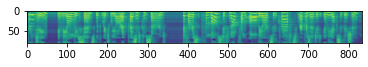

In [61]:
aligner.eval()
for i in range(5000): 
    durations = aligner(data.waveform.to("cuda"), data.waveforn_length, data.transcript).to(device)
    inputs_text = data.tokens.to(device)
    inputs_text_len = data.token_lengths.to(device)
    inputs_wavs = data.waveform.to(device)
    inputs_wavs_len = data.waveforn_length.to(device)
    
    specs_GT = featurizer(inputs_wavs)
    # for i, wav in enumerate(inputs_wavs):
    #     print(featurizer(wav[:inputs_wavs_len[i]]).shape)

    if durations.shape != inputs_text.shape:    # Проверка на совпадение размерностей
        print("log unequal dim")
    durations = (durations[:,:inputs_text.shape[-1]]) #Если размерности не совпадют то durations обрезается справа до длины максмального количесва символов в тексе
    durations = (durations / durations.sum(dim=1)[:, None]) # Нормализация до суммы 1 всех элементов 
    durations = durations * inputs_wavs_len[:, None] # Получили длины в индексах  wav для каждой буквы
    durations = durations.cumsum(dim=1).int() # Возврат совокупной суммы элементов по заданной оси.
    durations = torch.ceil(durations * specs_GT.shape[-1] / inputs_wavs_len.max()) #  переход в количесво фреймов 
    for j in range(len(durations)): # цикл для перехода от [[1, 2, 6, 11, 11, 11, 11 ],...] -> [[1, 2, 6, 11, 0, 0, 0 ],...] 
        row = torch.unique_consecutive(durations[j])
        durations[j] = F.pad(row, (0, durations.shape[-1] - row.shape[-1]), "constant", 0)

    for j in range(durations.shape[0]): # цикл для перехода от ат совокупной суммы элементов по заданной оси -> к последовательноси продолжительности фонемы D = [2, 2, 3, 1, 0, 0, 0],
        pred = 0
        for k in range(durations.shape[-1]):
            curr = durations[j][k]
            if pred != 0 and curr != 0:
                durations[j][k] -= pred
            pred += curr
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    spec_out, dur_out = model(inputs_text, durations)

    groud_true = torch.log(durations.clamp(1e-5)) 

    # print(spec_out)
    # print(dur_out)
    # break

    loss = loss_one(dur_out.squeeze(), groud_true) + loss_second(spec_out, specs_GT)
    print(loss)
    if i % 20 == 0:
        print(i)
        plt.imshow((spec_out[0]).cpu().detach().numpy())
    loss.backward()
    optimizer.step()

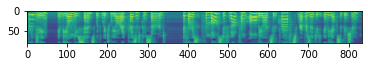

In [63]:
plt.imshow((spec_out[0]).cpu().detach().numpy())

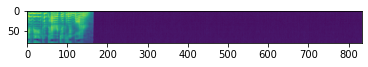

In [64]:
plt.imshow((spec_out[1]).cpu().detach().numpy())

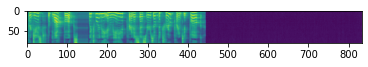

In [65]:
plt.imshow((spec_out[3]).cpu().detach().numpy())

In [66]:
reconstructed_wav = vocoder.inference(spec_out[0].unsqueeze(dim=0).cuda()).cpu()

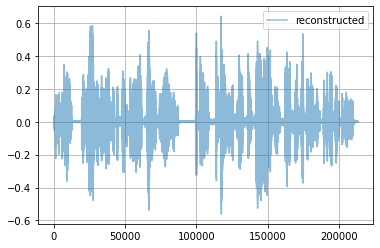

In [67]:
plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
plt.grid()
plt.legend()
plt.show()

In [68]:
display.display(display.Audio(reconstructed_wav, rate=22050))


In [69]:
reconstructed_wav = vocoder.inference(spec_out[1].unsqueeze(dim=0).cuda()).cpu()
display.display(display.Audio(reconstructed_wav, rate=22050))


In [70]:
reconstructed_wav = vocoder.inference(spec_out[2].unsqueeze(dim=0).cuda()).cpu()
display.display(display.Audio(reconstructed_wav, rate=22050))


In [71]:
reconstructed_wav = vocoder.inference(spec_out[3].unsqueeze(dim=0).cuda()).cpu()
display.display(display.Audio(reconstructed_wav, rate=22050))


# ALL data

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        durations = aligner(data.waveform.to("cpu"), data.waveforn_length, data.transcript)
        inputs_text = data.tokens
        inputs_text_len = data.token_lengths
        inputs_wavs = data.waveform
        inputs_wavs_len = data.waveforn_length

        specs_GT = featurizer(inputs_wavs)
        # for i, wav in enumerate(inputs_wavs):
        #     print(featurizer(wav[:inputs_wavs_len[i]]).shape)

        if durations.shape != inputs_text.shape:
            print("log unequal dim")
        durations = (durations[:,:inputs_text.shape[-1]])
        durations = (durations / durations.sum(dim=1)[:, None])
        durations = durations * inputs_wavs_len[:, None]
        durations = durations.cumsum(dim=1).int()
        durations = torch.ceil(durations * specs_GT.shape[-1] / inputs_wavs_len.max())
        for j in range(len(durations)):
            row = torch.unique_consecutive(durations[j])
            durations[j] = F.pad(row, (0, durations.shape[-1] - row.shape[-1]), "constant", 0)


        for j in range(durations.shape[0]):
            pred = 0
            for k in range(durations.shape[-1]):
                curr = durations[j][k]
                if pred != 0 and curr != 0:
                    durations[j][k] -= pred
                pred += curr

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        spec_out, dur_out = model(inputs_text, durations)

        groud_true = torch.log(durations)
        groud_true[groud_true == float('-inf')] = 0.

        loss = loss_one(dur_out.squeeze(), groud_true) + loss_second(spec_out, specs_GT)
        print(loss)
        loss.backward()
        optimizer.step()


# TRASH

In [ ]:
loss_one(dur_out.squeeze(), torch.log(durations))

tensor(inf, grad_fn=<MseLossBackward0>)

In [ ]:
durations

In [ ]:
dur_out.squeeze().shape

torch.Size([5, 131])

In [ ]:
inputs_text.shape

torch.Size([5, 131])

In [ ]:
dur_out.shape

torch.Size([5, 116, 1])

In [ ]:
data.durations[0] * data.waveforn_length[0]

In [ ]:
prim = data.durations[1]
prim 

In [ ]:
prim.sum()

tensor(0.9459)

In [ ]:
prim = prim / prim.sum()
prim

In [ ]:
data.durations[1].sum()

tensor(0.9459)

In [ ]:
(data.durations / data.durations.sum(dim=1)[:,None])

In [ ]:
specs_GT.shape

torch.Size([5, 80, 665])

In [ ]:
inputs_wavs_len

tensor([119197, 130717, 139421, 170141, 160413], dtype=torch.int32)

In [ ]:
inputs_wavs_len.max() * specs_GT.shape[-1] 

tensor(113143765, dtype=torch.int32)

In [ ]:
torch.ceil(inputs_wavs_len[:]* specs_GT.shape[-1] / inputs_wavs_len.max())

tensor([466., 511., 545., 665., 627.])

In [ ]:
plt.imshow((specs_GT[0]))

In [ ]:
(data.durations / data.durations.sum(dim=1)[:,None])

In [ ]:
torch.ceil(inputs_wavs_len[:]* specs_GT.shape[-1] / inputs_wavs_len.max())

tensor([466., 511., 545., 665., 627.])

In [ ]:
specs_GT.shape

torch.Size([5, 80, 665])

In [ ]:
torch.ceil(inputs_wavs_len[:]* specs_GT.shape[-1] / inputs_wavs_len.max())

tensor([466., 511., 545., 665., 627.])

In [ ]:
# (input_dur * torch.ceil(inputs_wavs_len[:]* specs_GT.shape[-1] / inputs_wavs_len.max())[:, None])

# Trash

In [ ]:
data.waveforn_length[index]

tensor(119197, dtype=torch.int32)

In [ ]:
index = 4

waveform = data.waveform[index]
durations = data.durations[index]


In [ ]:
durations = (data.durations[index] / data.durations[index].sum())
durations.sum()

tensor(1.0000)

In [ ]:
durations = durations * data.waveforn_length[index]
durations = durations.cumsum(dim=0).int()

In [ ]:
durations

In [ ]:
plt.imshow(featurizer(waveform))

In [ ]:
featurizer(waveform).shape

torch.Size([80, 665])

In [ ]:
durations

In [ ]:
data.waveforn_length[:,None]

In [ ]:
torch.ceil(durations* specs_GT.shape[-1] / data.waveforn_length[:].max())

In [ ]:
featurizer(waveform).shape

torch.Size([80, 665])

In [ ]:
164

164

# Trash too


In [ ]:
data.durations

In [ ]:
waveform = data.waveform
durations = data.durations
print(durations)
durations = (data.durations / data.durations[:].sum(dim=1)[:, None])
durations = durations * data.waveforn_length[:, None]
durations = durations.cumsum(dim=1).int()
torch.ceil(durations * specs_GT.shape[-1] / data.waveforn_length[:].max()).shape

In [ ]:
out = torch.ceil(durations * specs_GT.shape[-1] / data.waveforn_length[:].max())

In [ ]:
out.shape

In [ ]:
out[:,-12:]

In [ ]:
(out[:,:dur_out.squeeze().shape[-1]])[:,-10:]

In [ ]:
for i, wav in enumerate(inputs_wavs):
    print(featurizer(wav[:inputs_wavs_len[i]]).shape)

In [ ]:
waveform = data.waveform
durations = data.durations

In [ ]:
durations = (data.durations / data.durations[:].sum(dim=1)[:, None])

In [ ]:
durations = durations * data.waveforn_length[:, None]
durations = durations.cumsum(dim=1).int()

In [ ]:
out = torch.ceil(durations * specs_GT.shape[-1] / data.waveforn_length[:].max())
out

In [ ]:
out.shape[-1]

In [ ]:
row.shape[-1]

In [ ]:
out.shape[-1] - row.shape

In [ ]:
for i in out:
    row = torch.unique_consecutive(i)
    row = F.pad(row, (0, out.shape[-1] - row.shape[-1]), "constant", 0)
    print(row)

In [ ]:
sha

In [ ]:
torch.unique_consecutive(out[0]).shape

In [ ]:
  F.pad(torch.unique_consecutive(out[0]), (0, 4), "constant", 0)

In [ ]:
for i

In [ ]:
len(durations)

5

In [ ]:
for_time.shape, durations.shape[0]

In [ ]:
durations = durations.long()

In [ ]:
durations

In [ ]:
torch.sum(durations, dim=-1).max()

tensor(742)

In [ ]:
for i, wav in enumerate(inputs_wavs):
    print(featurizer(wav[:inputs_wavs_len[i]]).shape)

In [ ]:
outp = torch.zeros((for_time.shape[0], torch.sum(durations, dim=-1).max(), for_time.shape[-1]))

In [ ]:
outp.shape

torch.Size([5, 742, 384])

In [ ]:
outp = torch.zeros((for_time.shape[0], torch.sum(durations, dim=-1).max(), for_time.shape[-1]))
N, L = durations.shape
for j in range(N):
    count = 0
    for k in range(L):
        kol = durations[j][k]
        if kol != 0:
            outp[j,count:count+kol] = for_time[j,k]
            print(count,count+kol, for_time[j,k][:6])
            count += kol


In [ ]:
outp.shape

In [ ]:
# outp[0][416]

In [ ]:
for i in for_time[-1]:
    print(i[:5])

In [ ]:
durations[-1]

In [ ]:
outp[0][-:]

In [ ]:
outp

In [ ]:
durations

In [ ]:
for i in range(durations.shape[0]):
    pred = 0
    for j in range(durations.shape[-1]):
        curr = durations[i][j]
        if pred != 0 and curr != 0:
            durations[i][j] -= pred
        pred += curr

In [ ]:
durations

In [ ]:
durations